<a href="https://colab.research.google.com/github/Maxipat/Data-Science-Capstone-project/blob/master/Copy_of_Flower_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pandas as pd
import numpy as np
import os
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [ ]:
model_name = "mobilenet_v3_large_075_224"


model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

In [ ]:
model_hand = model_handle_map.get(model_name)

pixels = model_image_size_map.get(model_name, 224)
print(f"Selected model: {model_name} : {model_hand}")

img_sze = (pixels, pixels)
print(f"Input size {img_sze}")

batch_size =  32

Selected model: mobilenet_v3_large_075_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5
Input size (224, 224)


In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [ ]:
def build_data(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.20,
                                                             label_mode = 'categorical',
                                                             batch_size = 1, subset = subset,
                                                             seed = 123, image_size = img_sze)
  

training_ds = build_data("training")
class_names = tuple(training_ds.class_names)
training_size = training_ds.cardinality().numpy()
training_ds = training_ds.unbatch().batch(batch_size)
training_ds = training_ds.repeat()

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

preprocessing_mod = tf.keras.Sequential([normalization_layer])

do_data_augmentation = False

if do_data_augmentation:
  preprocessing_mod.add(tf.keras.layers.experimental.preprocessing.RandomRotation(40))
  preprocessing_mod.add(tf.keras.layers.experimental.preprocessing.RandomTranslation(0, 0.2))
  preprocessing_mod.add(tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0))
  preprocessing_mod.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
  preprocessing_mod.add(tf.keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal"))


training_ds = training_ds.map(lambda images, labels: (preprocessing_mod(images), labels))


  

validation_ds =  build_data("validation")
validation_size = validation_ds.cardinality().numpy()
validation_ds = validation_ds.unbatch().batch(batch_size)

validation_ds = validation_ds.map(lambda images, labels: (normalization_layer(images), labels))




Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
do_fine_tuning = False

In [ ]:
print("Building model with", model_hand)

# model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape = img_sze + (3,)), 
#                              hub.KerasLayer(model_hand, trainable = do_fine_tuning),
#                              tf.keras.layers.Dropout(rate =0.2),
#                              tf.keras.layers.Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])

# model.build((None, )+img_sze+(3, ))
# model.summary()


model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=img_sze + (3,)),
    hub.KerasLayer(model_hand, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+img_sze+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_13 (KerasLayer)  (None, 1280)              2731616   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 6405      
Total params: 2,738,021
Trainable params: 6,405
Non-trainable params: 2,731,616
_________________________________________________________________


In [ ]:
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits =True, label_smoothing= 0.1), 
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
steps_per_epochs = training_size// batch_size
validation_steps = validation_size// batch_size

hist = model.fit(
    training_ds,
    epochs = 5,
    steps_per_epoch = steps_per_epochs,
    validation_data = validation_ds,
    validation_steps = validation_steps).history


Epoch 1/5
91/91 [==============================] - 88s 911ms/step - loss: 0.8955 - accuracy: 0.7545 - val_loss: 0.6690 - val_accuracy: 0.8821
Epoch 2/5
91/91 [==============================] - 81s 898ms/step - loss: 0.6529 - accuracy: 0.8933 - val_loss: 0.6373 - val_accuracy: 0.8963
Epoch 3/5
91/91 [==============================] - 81s 891ms/step - loss: 0.6151 - accuracy: 0.9108 - val_loss: 0.6247 - val_accuracy: 0.9062
Epoch 4/5
91/91 [==============================] - 81s 889ms/step - loss: 0.5935 - accuracy: 0.9301 - val_loss: 0.6129 - val_accuracy: 0.9162
Epoch 5/5
91/91 [==============================] - 80s 885ms/step - loss: 0.5752 - accuracy: 0.9401 - val_loss: 0.6101 - val_accuracy: 0.9119


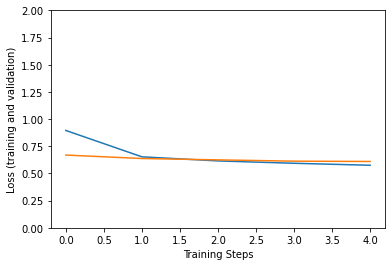

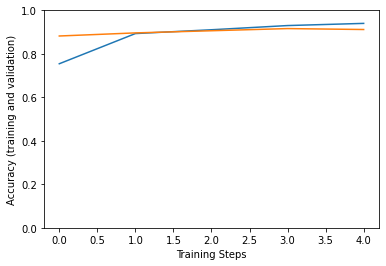

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

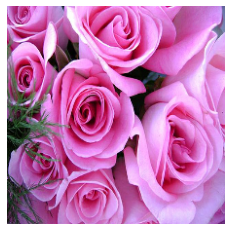

In [ ]:
x, y = next(iter(validation_ds))
image= x[0, :, :, :]
true_index = np.argmax(y[10])

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
prediction_scores = model.predict(np.expand_dims(image, axis = 0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

True label: daisy
Predicted label: roses
